In [31]:
# Importing modules
import pandas as pd
import os
import re
import gensim
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt


In [32]:
data=pd.read_csv('/content/drive/MyDrive/ISE/CSV/final_1.csv',index_col=None)
data.head()

,Name,No_of_closed_issues,No_of_open_issues,topics,url,user_name,total_issues
0,tensorflow,43782.0,4029.0,"['tensorflow', 'machine-learning', 'python', '...",https://github.com/tensorflow/tensorflow.git,tensorflow,47811.0
1,keras,11296.0,3238.0,"['deep-learning', 'tensorflow', 'neural-networ...",https://github.com/keras-team/keras.git,keras-team,14534.0
2,pytorch,46234.0,8415.0,"['neural-network', 'autograd', 'gpu', 'numpy',...",https://github.com/pytorch/pytorch.git,pytorch,54649.0
3,scikit-learn,17271.0,2365.0,"['machine-learning', 'python', 'statistics', '...",https://github.com/scikit-learn/scikit-learn.git,scikit-learn,19636.0
4,TensorFlow-Examples,173.0,210.0,"['tensorflow', 'tutorial', 'examples', 'deep-l...",https://github.com/aymericdamien/TensorFlow-Ex...,aymericdamien,383.0


In [33]:
data = data.drop(columns=['Name', 'No_of_closed_issues', 'No_of_open_issues', 
                              'url', 'user_name', 'total_issues'], axis=1)
data.head()

,topics
0,"['tensorflow', 'machine-learning', 'python', '..."
1,"['deep-learning', 'tensorflow', 'neural-networ..."
2,"['neural-network', 'autograd', 'gpu', 'numpy',..."
3,"['machine-learning', 'python', 'statistics', '..."
4,"['tensorflow', 'tutorial', 'examples', 'deep-l..."


In [34]:
# Remove punctuation
data['topics_processed'] = data['topics'].map(lambda x: re.sub('[,\.!?]', '', x))
data['topics_processed'] = data['topics_processed'].map(lambda x: re.sub("\'","",x))
# Convert the titles to lowercase
data['topics_processed'] = data['topics_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
data['topics_processed'].head()

<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-34-69caa85aeb10>:2: DeprecationWarning: invalid escape sequence \.
  data['topics_processed'] = data['topics'].map(lambda x: re.sub('[,\.!?]', '', x))


0    [tensorflow machine-learning python deep-learn...
1    [deep-learning tensorflow neural-networks mach...
2    [neural-network autograd gpu numpy deep-learni...
3    [machine-learning python statistics data-scien...
4    [tensorflow tutorial examples deep-learning py...
Name: topics_processed, dtype: object

In [35]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
df = data.topics_processed.values.tolist()
data_words = list(sent_to_words(df))
print(data_words[:1][0][:30])

['tensorflow', 'machine', 'learning', 'python', 'deep', 'learning', 'deep', 'neural', 'networks', 'neural', 'network', 'ml', 'distributed']


In [36]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [37]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
extra_stopwords=['numpy','scikit','math','pandas','dataframe','machine','python','machine-learning','question','answering','highschool','insurance','student','line']
stop_words.extend(extra_stopwords)
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [39]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
# Create Corpus
texts = data_words_bigrams
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1)]]


In [40]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [41]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.080*"learning" + 0.067*"language" + 0.058*"natural" + 0.048*"processing" '
  '+ 0.041*"nlp" + 0.018*"text" + 0.017*"ai" + 0.014*"time_series" + '
  '0.014*"labeling" + 0.012*"conversational"'),
 (1,
  '0.191*"data" + 0.102*"learning" + 0.086*"science" + 0.039*"analysis" + '
  '0.018*"research" + 0.015*"visualization" + 0.013*"statistics" + '
  '0.013*"mining" + 0.009*"statistical" + 0.009*"deep"'),
 (2,
  '0.099*"learning" + 0.019*"computing" + 0.016*"algorithms" + 0.014*"search" '
  '+ 0.014*"optimization" + 0.013*"quantum" + 0.013*"deep" + '
  '0.011*"distributed" + 0.010*"gui" + 0.010*"reinforcement"'),
 (3,
  '0.044*"learning" + 0.018*"gpu" + 0.014*"anime" + 0.011*"cpp" + '
  '0.011*"analysis" + 0.011*"financial" + 0.011*"automatic" + 0.010*"matrix" + '
  '0.010*"pi" + 0.010*"raspberry"'),
 (4,
  '0.116*"learning" + 0.044*"tensorflow" + 0.036*"deep" + 0.025*"notebook" + '
  '0.023*"keras" + 0.021*"jupyter" + 0.019*"learn" + 0.018*"ml" + '
  '0.018*"neural" + 0.016*"pytorc

In [42]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.36482260893898194


Lets tune some hyper parameters such as number of topics,alpha,beta
alpha=document-topic density
beta=word-topic density

In [43]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [44]:
len(corpus)

750

In [45]:
# import numpy as np
# import tqdm
# grid = {}
# grid['Validation_Set'] = {}
# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)
# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
# # Validation sets
# num_of_docs = len(corpus)
# # corpus_sets = [gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
# #                gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 

# # corpus_sets=[gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
# #                corpus]
# # corpus_title = ['75% Corpus', '100% Corpus']
# model_results = {
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }
# # Can take a long time to run
# if 1 == 1:

#   pbar = tqdm.tqdm(total=750)
    
#   for k in topics_range:
#       # iterate through alpha values
#       for a in alpha:

#         # iterare through beta values
#           for b in beta:
#                 # get the coherence score for the given parameters
#               cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                 # Save the model results
#                 # model_results['Validation_Set'].append(corpus_title[i])
#               model_results['Topics'].append(k)
#               model_results['Alpha'].append(a)
#               model_results['Beta'].append(b)
#               model_results['Coherence'].append(cv)
                    
#               pbar.update(1)
# pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
# pbar.close()

In [46]:
lda_data=pd.read_csv('lda_tuning_results.csv',index_col=None)
lda_data.head()

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.441245
1,2,0.01,0.31,0.444432
2,2,0.01,0.61,0.444432
3,2,0.01,0.9099999999999999,0.435531
4,2,0.01,symmetric,0.426920


In [47]:
topics=lda_data['Topics'].values.tolist()
coherence=lda_data['Coherence'].values.tolist()
Alpha=lda_data['Alpha'].values.tolist()
Beta=lda_data['Beta'].values.tolist()
x=[]
y=[]
for i in range(len(lda_data)):
  if Alpha[i]=='0.01' and Beta[i]=='0.31':
    x.append(topics[i])
    y.append(coherence[i])



print(x)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


Text(0, 0.5, 'coherence')

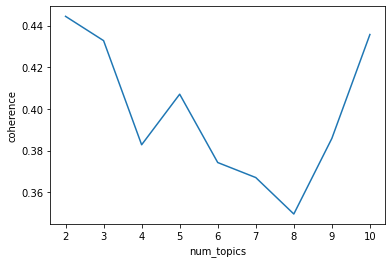

In [48]:
plt.plot(x,y)
plt.xlabel("num_topics")
plt.ylabel("coherence")

it is giving high coherence score for 10 number of topics.


In [49]:
alpha_list=[]
y=[] #for topics=10
for i in range(len(lda_data)):
  if topics[i]==10 and Alpha[i]!='symmetric' and Alpha[i]!='asymmetric':
    alpha_list.append(Alpha[i])
    y.append(coherence[i])

In [50]:
len(alpha_list)

20

Text(0, 0.5, 'coherence')

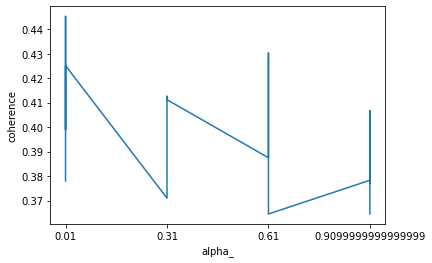

In [51]:
plt.plot(alpha_list,y)
plt.xlabel("alpha_")
plt.ylabel("coherence")

we can see the peak at alpha=0.01 we choose this

In [52]:
beta_list=[]
y=[] #for topics=10
for i in range(len(lda_data)):
  if topics[i]==10 and Beta[i]!='symmetric' and Beta[i]!='asymmetric':
    beta_list.append(Beta[i])
    y.append(coherence[i])

Text(0, 0.5, 'coherence')

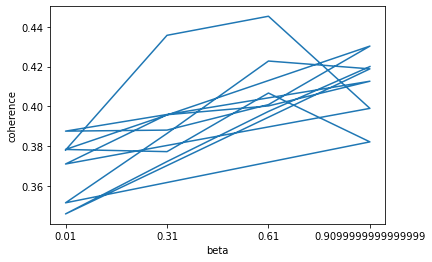

In [53]:
plt.plot(beta_list,y)
plt.xlabel("beta")
plt.ylabel("coherence")

we can see the peak is at 0.61 so we choose beta=0.61

final model parameters=
num_topics=10
alpha=0.01
beta=0.61
now making final model

In [57]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.61)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Visualizing topics


In [58]:
!pip install pyLDAvis==2.1.2

In [59]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.021815 -0.111058       1        1  43.565897
1     -0.110231  0.070529       2        1  28.359724
0      0.132046  0.040529       3        1  28.074379, topic_info=             Term        Freq       Total Category  logprob  loglift
8            data  229.000000  229.000000  Default  30.0000  30.0000
85     processing   84.000000   84.000000  Default  29.0000  29.0000
36       language   81.000000   81.000000  Default  28.0000  28.0000
84        natural   68.000000   68.000000  Default  27.0000  27.0000
7      tensorflow  164.000000  164.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
225           cnn   13.800909   28.007529   Topic3  -5.3453   0.5626
89   intelligence   19.635484   89.998426   Topic3  -4.9927  -0.2521
87     artificial   18.630256   90.880037   Topic3  -5.0453  -0.3144
86        pytorch   17.842891   96.721074   Topic3  -5.0885  -0.4199
6          neural   20.314138  175.259724   Topic3  -4.9588  -0.8846

[192 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
138       1  0.486086             ai
138       2  0.243043             ai
138       3  0.281418             ai
505       1  0.124768        airflow
505       2  0.873376        airflow
...     ...       ...            ...
182       2  0.618703  visualization
182       3  0.097690  visualization
1691      2  0.851173    wasserstein
270       1  0.093900           word
270       3  0.939003           word

[285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [29]:
from sklearn.model_selection import GridSearchCV